### SET UP AND VARIABLE DEFINITONS

In [23]:
## set up
import io
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50
from sklearn.model_selection import train_test_split
import helper_functions.spreadsheet_specific_helpers as helper


In [24]:
SHEETURL: str = (
    "https://docs.google.com/spreadsheets/d/"
    "1XcR48HZuC-mSFB-uKIxwPFhfRGVX7bWy100PhcLA8oM/"
    "edit?resourcekey=&gid=1780925762#gid=1780925762"
)

# format for CSV https://docs.google.com/spreadsheets/d/
# <SHEET_ID>/gviz/tq?tqx=
# out:csv&sheet=<SHEET_NAME>
SHEET_CSV_URL: str = (
    "https://docs.google.com/spreadsheets/d/"
    "1XcR48HZuC-mSFB-uKIxwPFhfRGVX7bWy100PhcLA8oM/"
    "gviz/tq?tqx=out:csv&sheet=Congregated Data"
)

In [ ]:
X_DEMO_COLS = ['Main SEAL group affiliation', 'All SEAL group affiliations',
       'Developed for SUDOKU Sheet Tools?', 'Age', 'Gender',
       'Sexual orientation', 'Race', 'Chronic condition',
       'Condition description', 'Economic class', 'Religion']
X_PERSONALITY_COLS = ['Game motivation', 'Internal / External game motivation',
       '[Introverted - Extroverted]', '[Critical - Trusting]',
       '[Spontaneous - Conscientious]', '[Self-conscious - Even-tempered]',
       '[Prefer similarity - Am open to change]']
X_SEAL_COLS = ['I feel like I am playing a game. ',
       'I consider myself to be highly experienced.',
       'Aesthetically pleasing.', 'Rank reflects work accurately.',
       'Leaderboard reflects work accurately.',
       'YBR reflects work accurately.', 'VisTools reflects work accurately.',
       'RaceTrack reflects work accurately.',
       'Battle Station reflects work accurately.',
       'Command Center reflects work accurately.',
       'I understand what my SEAL statistics mean.',
       'I know exactly how my actions affect my lab statistics (Lab HP, Sheet HP, YBR Gold Delta, and Training Score).',
       'Using the Sudoku Sheet Tools helps me and my team stay on track.',
       'Using the Sudoku Sheet Tools encourages me to take risks and challenge myself.',
       'Using the Sudoku Sheet Tools makes my work in SEAL more enjoyable.']
Y_COLS = ['Personal success', 'Teammate success', 'Peer success',
       'Satisfaction in SEAL']
X_USABILITY_COLS = ['I think that I would like to use this system frequently',
       'I found the system unnecessarily complex',
       'I thought the system was easy to use',
       'I think that I would need the support of a technical person to be able to use this system',
       'I found the various functions in this system were well integrated',
       'I thought there was too much inconsistency in this system',
       'I would imagine that most people would learn to use this system very quickly',
       'I found the system very cumbersome to use',
       'I felt very confident using the system',
       'I needed to learn a lot of things before I could get going with this system.']
X_DROP_COLS = ['All SEAL group affiliations']

### Extract the data

In [25]:
def get_data() -> DataFrame:  # idealy we dont want to us Any, but for now
    """function to get the data from the google sheet
    raises: HTTPError: if the request fails (meaning url wrong or no inter)

    @returns: @type(DataFrame): the data from the google sheet"""

    response = requests.get(SHEET_CSV_URL)
    response.raise_for_status()  # Raise error if request fails
    df: DataFrame = pd.read_csv(io.StringIO(response.text))
    return df

In [30]:
## ORIGINAL
data = get_data()
columns = data.columns
print(columns)
print(data.shape) # 81 x 47


Index(['Main SEAL group affiliation', 'All SEAL group affiliations',
       'Developed for SUDOKU Sheet Tools?', 'Age', 'CONGREGATED GENDER',
       'Sexual orientation', 'Race', 'Chronic condition',
       'Condition description', 'Economic class', 'Religion',
       'Game motivation', 'Internal / External game motivation',
       '[Introverted - Extroverted]', '[Critical - Trusting]',
       '[Spontaneous - Conscientious]', '[Self-conscious - Even-tempered]',
       '[Prefer similarity - Am open to change]',
       'I feel like I am playing a game. ',
       'I consider myself to be highly experienced.',
       'Aesthetically pleasing.', 'Rank reflects work accurately.',
       'Leaderboard reflects work accurately.',
       'YBR reflects work accurately.', 'VisTools reflects work accurately.',
       'RaceTrack reflects work accurately.',
       'Battle Station reflects work accurately.',
       'Command Center reflects work accurately.',
       'I understand what my SEAL statistics

In [11]:
x_data = data.drop(columns=X_DROP_COLS + Y_COLS)
split_col: DataFrame = helper.split_motivation_column(x_data)
print(x_data.columns)

Index(['What group are you primarily affiliated with in SEAL Life (shows up in SEAL clan life)?',
       'AGE (Congregated)', 'Gender (CONGREGATED)',
       'How do you describe your sexual orientation?',
       'Which categories best describe you?',
       'Do you have any chronic condition that substantially limit your life activities?',
       'If you have a disability, please indicate (if comfortable) the terms that best describe the condition(s)',
       'Which economic class do you identify with?', 'RELIGION (Congregated)',
       'When playing games, I am most motivated by...',
       'I consider myself to be...',
       'When playing games, I consider myelf to be... [Introverted - Extraverted]',
       'When playing games, I am generally... [Critical - Trusting]',
       'When playing games, I prefer to be...[Spontaneous - Conscientious]',
       'When playing games, I consider myself to be...[Self conscious- even tempered]',
       'When playing games, I generally...[Prefer si

In [ ]:
def split_xy(data, drop_cols):
    """function to split the x and y data into separate ndarrays based on
    a set of columns to be dropped

    @parameter: data @type(DataFrame): unprocessed data 
    @parameter: drop_cols @type(ndarray): array of names of columns to drop

    @returns: @type(ndarray): relevant x-values from data
    @returns: @type(ndarray): y-values from data"""

    x_data = data.drop(columns=X_DROP_COLS + Y_COLS)

    # split motivation columns:
    split_col: DataFrame = helper.split_motivation_column(x_data)
    x_data.drop('When playing games, I am most motivated by...', axis = 1, inplace = True)
    x_data = pd.concat([x_data, split_col], axis=1)

    # handle X_SEAL_COLS: map disagree - agree as 1-5
    options_map = {'Strongly disagree': 1,
                    'Disagree': 2,
                    'Neutral': 3,
                    'Agree': 4,
                    'Strongly agree': 5
                    }
    x_data[X_SEAL_COLS] = x_data[X_SEAL_COLS].replace(options_map)

    # Handle NaNs with data imputation of average or 'No Response'
    x_data[X_PERSONALITY_COLS[1:2]] = x_data[X_PERSONALITY_COLS[1:2]].fillna('No Response')
    x_data[X_PERSONALITY_COLS[2]] = x_data[X_PERSONALITY_COLS[2]].fillna(3)
    x_data[X_PERSONALITY_COLS[3:]] = x_data[X_PERSONALITY_COLS[3:]].fillna(3)
    x_data[X_DEMO_COLS] = x_data[X_DEMO_COLS].fillna('No Response')
    x_data[X_SEAL_COLS] = x_data[X_SEAL_COLS].fillna(3)
    x_data[X_USABILITY_COLS] = x_data[X_USABILITY_COLS].fillna(3)
    data[Y_COLS] = data[Y_COLS].fillna(3)

    # one-hot-encoding for categorical data (demographics, gaming)
    cat_col = x_data.select_dtypes(include=['object', 'category']).columns
    x_data = pd.get_dummies(x_data, columns = cat_col)
    y_data = data[Y_COLS]
    return x_data, y_data

In [18]:
x_data, y_data = split_xy(data, X_DROP_COLS)
x_train, x_temp, y_train, y_temp = train_test_split(x_data, y_data, test_size=0.3)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.33)

print(x_data.columns)
#print(x_train.shape, y_train.shape)
#print(x_val.shape, y_val.shape)
#print(x_test.shape, y_test.shape)

Index(['When playing games, I consider myelf to be... [Introverted - Extraverted]',
       'When playing games, I am generally... [Critical - Trusting]',
       'When playing games, I prefer to be...[Spontaneous - Conscientious]',
       'When playing games, I consider myself to be...[Self conscious- even tempered]',
       'When playing games, I generally...[Prefer similarity - Am open to change]',
       'When I use the SEAL Sudoku Sheet Tools, I feel like I am playing a game. ',
       'I consider myself to be highly experienced with the SEAL Sheet Tools.',
       'I find the Sudoku Sheet Tools to be aesthetically pleasing.',
       'I think SEAL rank reflect my work and my team's work accurately.',
       'I think SEAL leaderboard reflect my work and my team's work accurately.',
       'I think SEAL YBR reflect my work and my team's work accurately.',
       'I think SEAL VisTools reflect my work and my team's work accurately.',
       'I think SEAL RaceTrack reflect my work and my

In [37]:
def standardize(x_train, x_val, x_test):
    """function that standardizes data to normal gaussian distribution.
    Standardization calculation is applied only to the training data.

    @parameter: x_train @type(nd.array) processed x training data to be standardized
    @parameter: x_val @type(nd.array) processed x val data to be standardized
    @paremeter: x_test @type(nd.array) processed x-test data to be standardized
    """
    scaler = StandardScaler().fit(x_train)  # only fit on training data
    x_train_stand = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns, index=x_train.index)
    x_val_stand = pd.DataFrame(scaler.transform(x_val), columns=x_val.columns, index=x_val.index)
    x_test_stand = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns, index=x_test.index)
    return x_train_stand, x_val_stand, x_test_stand

In [38]:

lasso_data = pd.DataFrame(
    columns=['l1_penalty', 'model', 'rmse_train', 'rmse_validation'])
l1_lambdas = np.logspace(-4, 4, 100)
for l1 in l1_lambdas:
    lasso_model = Lasso(alpha=l1)
    lasso_model.fit(x_train, y_train)  # model
    lasso_predict = lasso_model.predict(x_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, lasso_predict))

    lasso_val = lasso_model.predict(x_train)
    rmse_validation = np.sqrt(mean_squared_error(y_train, lasso_val))
    lasso_data.loc[len(lasso_data)] = [l1, lasso_model, rmse_train, rmse_validation]
    

c:\Users\kelly\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.905e-02, tolerance: 3.685e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\kelly\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.629e-02, tolerance: 3.770e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\kelly\anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.336e-02, tolerance: 

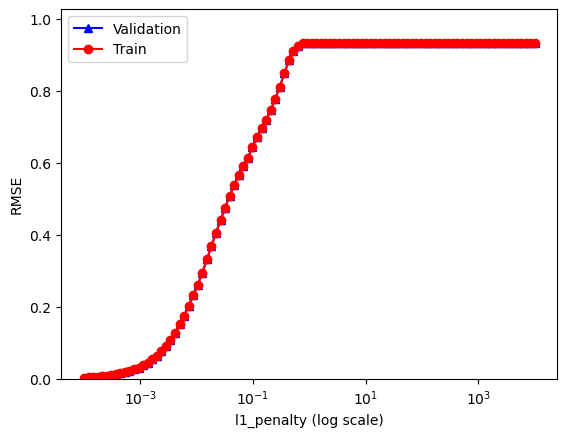

In [40]:
plt.plot(lasso_data['l1_penalty'], lasso_data['rmse_validation'],
         'b-^', label='Validation')

# Plot the train RMSE as a red line dots
plt.plot(lasso_data['l1_penalty'], lasso_data['rmse_train'],
         'r-o', label='Train')

# Set y-limits
rmse_max = max(lasso_data['rmse_train'].max(), lasso_data['rmse_validation'].max())
rmse_max *= 1.1  # Give a little buffer
plt.ylim(0, rmse_max)

# Make the x-axis log scale for readability
plt.xscale('log')

# Label the axes and make a legend
plt.xlabel('l1_penalty (log scale)')
plt.ylabel('RMSE')
plt.legend()

In [41]:
def linear_regression(x_train, y_train, x_val, y_val):
    models = []
    train_rmse = []
    val_rmse = []
    for i in range(y_train.shape[1]):
        y_t = y_train.iloc[:,i]
        y_v = y_val.iloc[:,i]
        model = LinearRegression().fit(x_train, y_t)
        predict_t = model.predict(x_train)
        t_rmse = np.sqrt(mean_squared_error(y_t, predict_t))
        predict_v = model.predict(x_val)
        v_rmse = np.sqrt(mean_squared_error(y_v, predict_v))

        train_rmse.append(t_rmse)
        val_rmse.append(v_rmse)
        models.append(model)
    print(x_train.columns)
    linear_visualization(models, x_train.columns, y_train.columns)
    return models, train_rmse, val_rmse

def linear_visualization(models, features, y_cols):
    for i, model in enumerate(models):
        coef = model.coef_

        coef_list = pd.DataFrame({"Feature": features, "Coef": coef})
        coef_list["abs"] = coef_list["Coef"].abs()
        top = coef_list.nlargest(10, "abs")
        print(top["Feature"], top["Coef"])

        plt.figure(figsize = (10,5))
        plt.barh(top["Feature"], top["Coef"])
        plt.xticks(rotation=45, ha="right")
        plt.xlabel("Features")
        plt.ylabel("Coef values")
        plt.title(f"{y_cols[i]}")
        plt.show()

Index(['When playing games, I consider myelf to be... [Introverted - Extraverted]',
       'When playing games, I am generally... [Critical - Trusting]',
       'When playing games, I prefer to be...[Spontaneous - Conscientious]',
       'When playing games, I consider myself to be...[Self conscious- even tempered]',
       'When playing games, I generally...[Prefer similarity - Am open to change]',
       'When I use the SEAL Sudoku Sheet Tools, I feel like I am playing a game. ',
       'I consider myself to be highly experienced with the SEAL Sheet Tools.',
       'I find the Sudoku Sheet Tools to be aesthetically pleasing.',
       'I think SEAL rank reflect my work and my team's work accurately.',
       'I think SEAL leaderboard reflect my work and my team's work accurately.',
       ...
       'When playing games, I am most motivated by..._Mastering the game, Earning the most points',
       'When playing games, I am most motivated by..._Mastering the game, Earning the most poin

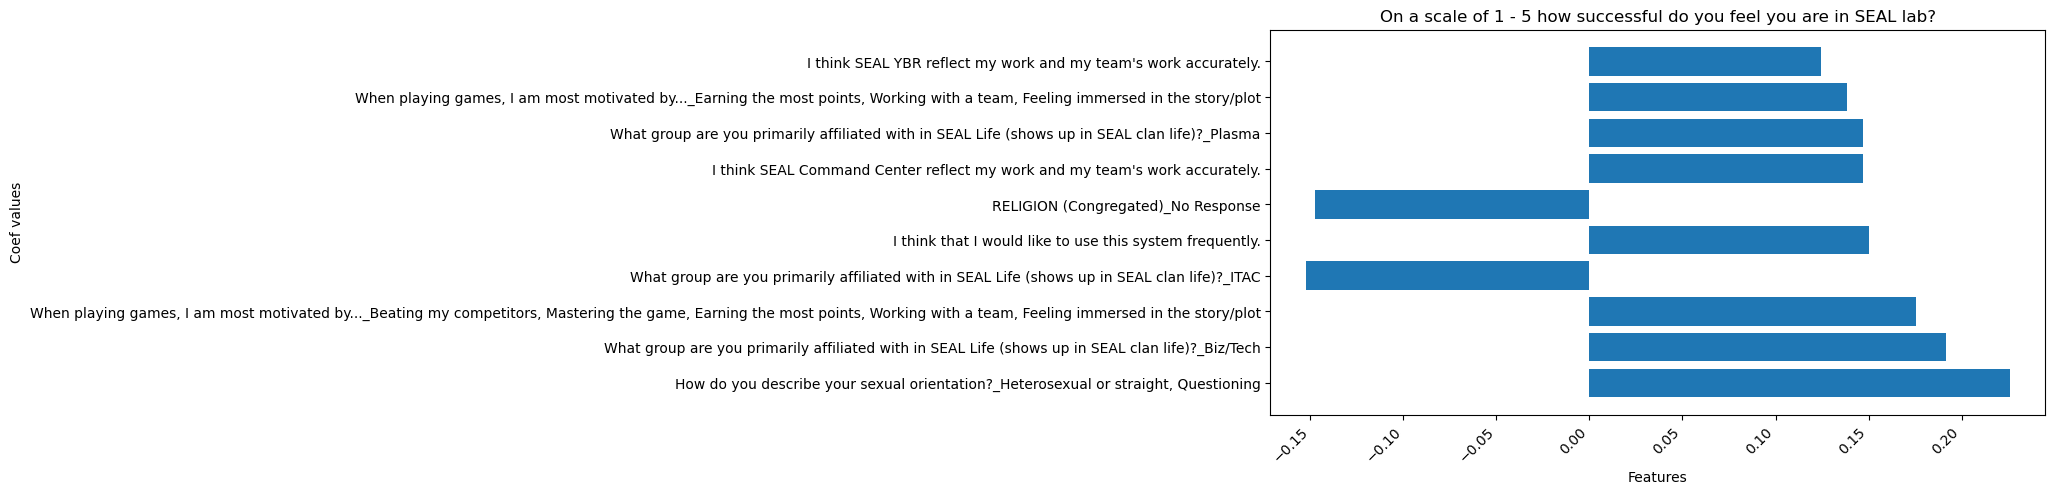

31     What group are you primarily affiliated with i...
30     What group are you primarily affiliated with i...
14     I think SEAL Command Center reflect my work an...
47     How do you describe your sexual orientation?_H...
104    When playing games, I am most motivated by..._...
18     Using the Sudoku Sheet Tools encourages me to ...
39                           Gender (CONGREGATED)_Female
41                             Gender (CONGREGATED)_Male
106    When playing games, I am most motivated by..._...
109    When playing games, I am most motivated by..._...
Name: Feature, dtype: object 31    -0.217760
30     0.217126
14     0.213246
47     0.212839
104    0.190161
18     0.184768
39    -0.180013
41     0.163563
106   -0.156919
109    0.155986
Name: Coef, dtype: float64


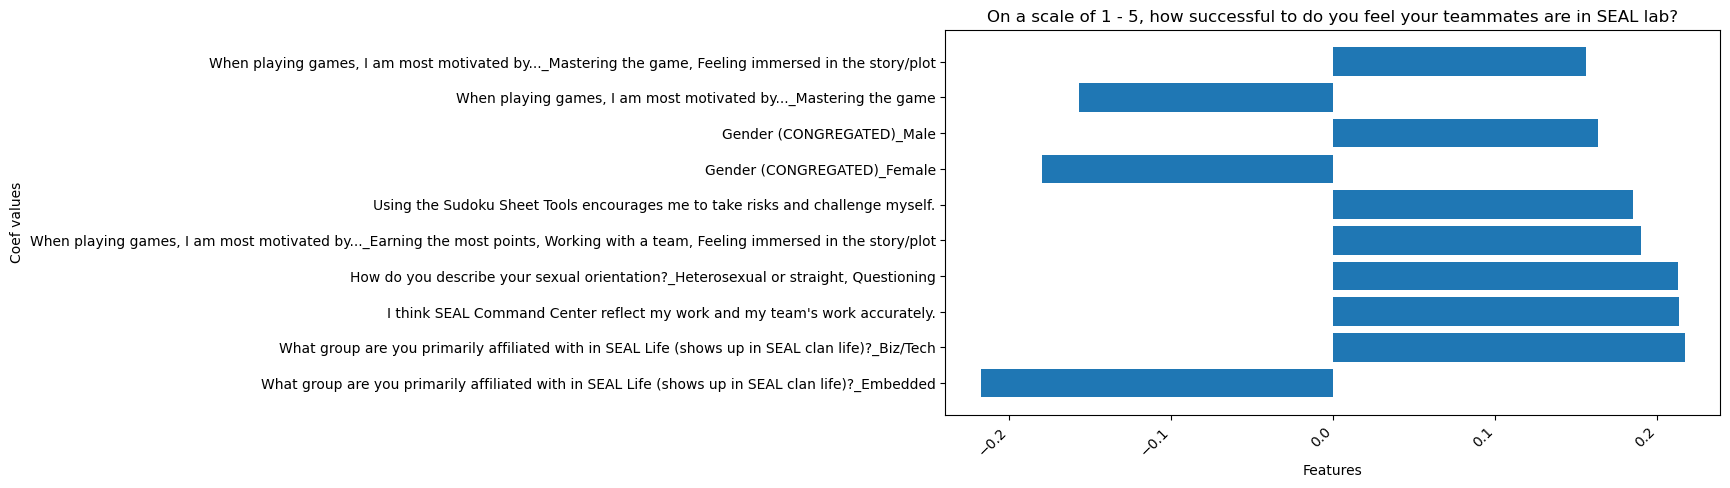

30     What group are you primarily affiliated with i...
14     I think SEAL Command Center reflect my work an...
20     I think that I would like to use this system f...
44     How do you describe your sexual orientation?_B...
34     What group are you primarily affiliated with i...
75                       RELIGION (Congregated)_Agnostic
78                       RELIGION (Congregated)_Atheist 
47     How do you describe your sexual orientation?_H...
106    When playing games, I am most motivated by..._...
105    When playing games, I am most motivated by..._...
Name: Feature, dtype: object 30     0.225659
14     0.214590
20     0.192095
44     0.191274
34     0.185762
75     0.170084
78    -0.165102
47     0.149531
106   -0.138003
105   -0.134481
Name: Coef, dtype: float64


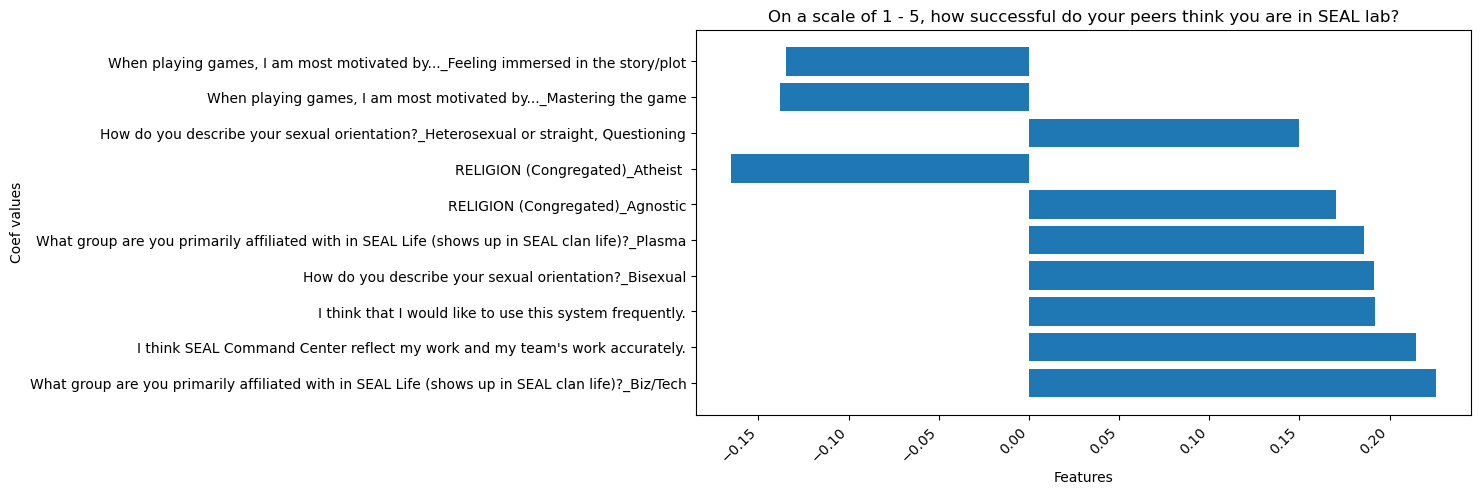

20     I think that I would like to use this system f...
104    When playing games, I am most motivated by..._...
47     How do you describe your sexual orientation?_H...
101    When playing games, I am most motivated by..._...
99     When playing games, I am most motivated by..._...
97     When playing games, I am most motivated by..._...
73     Which economic class do you identify with?_Wor...
74     Which economic class do you identify with?_Wor...
108    When playing games, I am most motivated by..._...
30     What group are you primarily affiliated with i...
Name: Feature, dtype: object 20     0.178512
104    0.140075
47     0.138982
101    0.132393
99     0.123725
97     0.123021
73    -0.120723
74     0.116147
108    0.115605
30     0.112836
Name: Coef, dtype: float64


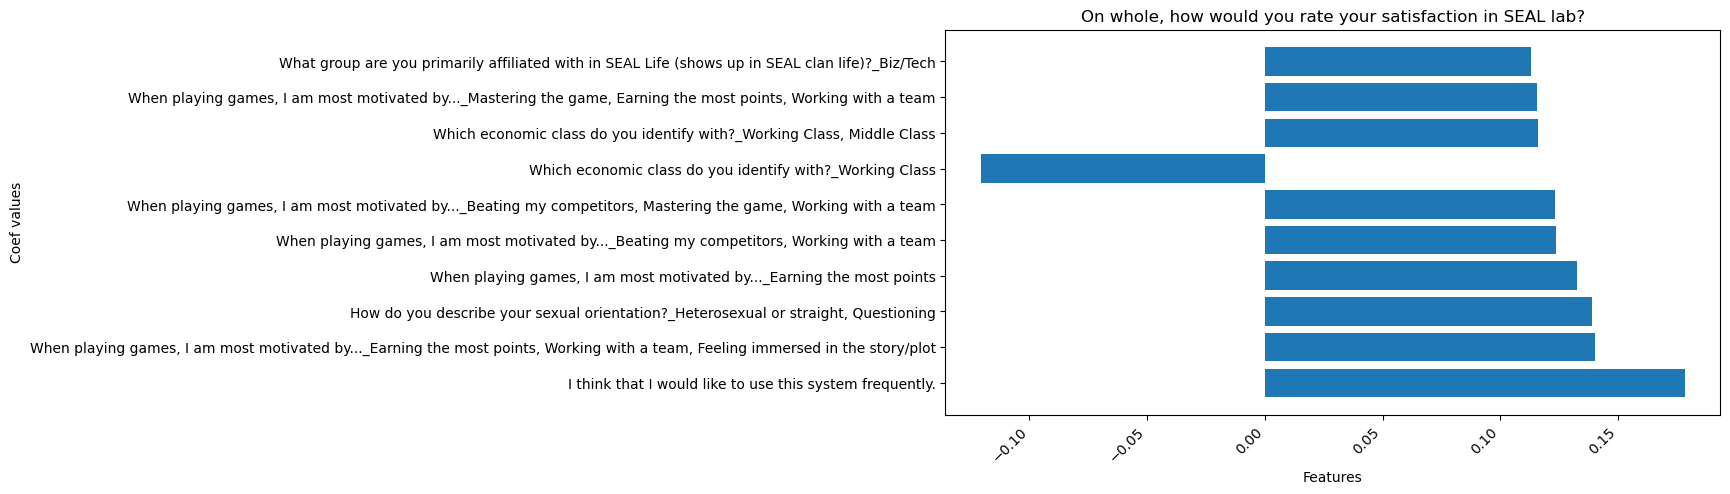

([LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression()],
 [3.5503507163317006e-15,
  2.7009008384189086e-15,
  2.722371437527392e-15,
  4.503404132147581e-15],
 [1.217217322558792,
  1.1696720639575542,
  1.5172770076505948,
  1.1704615207449527])

In [42]:
# Code to be executed when the script is run directly
data = get_data()

# pre-processing
x_data, y_data = split_xy(data, X_DROP_COLS)
y1, y2, y3, y4 = [y_data.iloc[:, i] for i in range(y_data.shape[1])]
x_nan = x_data.isna().sum().sum()
y_nan = y_data.isna().sum().sum()
#print("NaN values", x_nan, y_nan)
# NaN check


# 70% train 20% validation 10% test
x_train, x_temp, y_train, y_temp = train_test_split(
    x_data, y_data, test_size=0.3)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.33)

# normalization
x_train, x_val, x_test = standardize(x_train, x_val, x_test)
# feature selection

# model
linear_regression(x_train, y_train, x_val, y_val)

In [43]:
"""module to access data from google sheet, for getting set up with pandas"""
# ^^^ the above is documentation style comments
# this is used to describe modules, but also important to put in functions
# and classes. This is the equivalent to /** */ in java and enables hovering
# to check annotations.
# these usually go inside or in the "middle" of the function
# but still before the code starts
import io
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso


# for stubs, if it says ur missing them do   mypy --install-types
# use pylint, mypy and pep8 extensions as linters (you might have to install
# with pip inaddition to the python extension)
# this is what types look like in python, we are going to use this to type
# hint our functions
# and also to help us keep track of variables

# global variables from javascript!
# but notice the lenght of the coding lines, this is a python convention.
# get the data at
SHEETURL: str = (
    "https://docs.google.com/spreadsheets/d/"
    "1sptWDnGOyRcEyCHFYhyC8Y_zXGGM5jMpePRVusoSkFs/"
    "edit?resourcekey=&gid=1530912831#gid=1530912831"
)

# format for CSV https://docs.google.com/spreadsheets/d/
# <SHEET_ID>/gviz/tq?tqx=
# out:csv&sheet=<SHEET_NAME>
SHEET_CSV_URL: str = (
    "https://docs.google.com/spreadsheets/d/"
    "1sptWDnGOyRcEyCHFYhyC8Y_zXGGM5jMpePRVusoSkFs/"
    "gviz/tq?tqx=out:csv&sheet=Altered/congregrated data"
)

# global variables for our current data purposes
Y_COLS = [
    "On a scale of 1 - 5 how successful do you feel you are in SEAL lab?",
    "On a scale of 1 - 5, how successful to do you feel your teammates are in SEAL lab?",
    "On a scale of 1 - 5, how successful do your peers think you are in SEAL lab?",
    "On whole, how would you rate your satisfaction in SEAL lab?"
]
# G:N
X_DEMO_COLS = [
    "What group are you primarily affiliated with in SEAL Life (shows up in SEAL clan life)?",
    "AGE (Congregated)",
    "Gender (CONGREGATED)",
    "How do you describe your sexual orientation?",
    "Which categories best describe you?",
    "Do you have any chronic condition that substantially limit your life activities?",
    "If you have a disability, please indicate (if comfortable) the terms"
    " that best describe the condition(s)",
    "Which economic class do you identify with?",
    "RELIGION (Congregated)"
]
# O:U
X_GAME_COLS = [
    "When playing games, I am most motivated by...",
    "I consider myself to be...",
    "When playing games, I consider myself to be...",
    "When playing games, I am generally...",
    "When playing games, I prefer to be...",
    "When playing games, I consider myself to be...",
    "When playing games, I generally..."
]
# V:AJ
X_SEAL_COLS = [
    "When I use the SEAL Sudoku Sheet Tools, I feel like I am playing a game. ",
    "I consider myself to be highly experienced with the SEAL Sheet Tools.",
    "I find the Sudoku Sheet Tools to be aesthetically pleasing.",
    "I think SEAL rank reflect my work and my team's work accurately.",
    "I think SEAL leaderboard reflect my work and my team's work accurately.",
    "I think SEAL YBR reflect my work and my team's work accurately.",
    "I think SEAL VisTools reflect my work and my team's work accurately.",
    "I think SEAL RaceTrack reflect my work and my team's work accurately.",
    "I think SEAL Battle Station reflect my work and my team's work accurately.",
    "I think SEAL Command Center reflect my work and my team's work accurately.",
    "I understand what my SEAL statistics mean (Lab HP, Sheet HP, YBR Gold Delta, and Training Score).",
    "I know exactly how my actions affect my lab statistics (Lab HP, Sheet HP, YBR Gold Delta, and Training Score).",
    "Using the Sudoku Sheet Tools helps me and my team stay on track.",
    "Using the Sudoku Sheet Tools encourages me to take risks and challenge myself.",
    "Using the Sudoku Sheet Tools makes my work in SEAL more enjoyable."
]
# AO:AX
X_USABILITY_COLS = [
    "I think that I would like to use this system frequently.",
    "I found the system unnecessarily complex.",
    "I thought the system was easy to use.",
    "I think that I would need the support of a technical person to be able to use this system.",
    "I found the various functions in this system were well integrated.",
    "I thought there was too much inconsistency in this system.",
    "I would imagine that most people would learn to use this system very quickly.",
    "I found the system very cumbersome to use.",
    "I felt very confident using the system.",
    "I needed to learn a lot of things before I could get going with this system."
]
X_DROP_COLS = [
    "Timestamp",
    "Sudoku Sheet Tools are all the tools you use when actively engaging with SEAL life. "
    "Like Sudoku Clan Life, Dashboard, VisTools, RaceTrack, YBR, Kanban, Rank, Battle station, Venue, etc.",
    "What groups are you affiliated with in SEAL Life?",
    "Have you ever developed software as a programmer for Sudoku Sheet Tools?",
    "What is your current age?",
    "On scale of 1-10, how confusing were the questions on this survey?",
    "If you have any, we appreciate any additional feedback on the structure and questions within the survey",
    "SUS Overall score",
    "Learnability subscore",
    "Usability subscore"
]


def get_data() -> DataFrame:  # idealy we dont want to us Any, but for now
    """function to get the data from the google sheet
    raises: HTTPError: if the request fails (meaning url wrong or no inter)

    @returns: @type(DataFrame): the data from the google sheet"""

    response = requests.get(SHEET_CSV_URL)
    response.raise_for_status()  # Raise error if request fails
    df: DataFrame = pd.read_csv(io.StringIO(response.text))
    return df


def main():
    """main function to run the script"""
    # Code to be executed when the script is run directly
    data = get_data()

    # pre-processing
    x_data, y_data = split_xy(data, X_DROP_COLS)
    y1, y2, y3, y4 = [y_data.iloc[:, i] for i in range(y_data.shape[1])]
    x_nan = x_data.isna().sum().sum()
    y_nan = y_data.isna().sum().sum()
    print("NaN values", x_nan, y_nan)
    # NaN check


    # 70% train 20% validation 10% test
    x_train, x_temp, y_train, y_temp = train_test_split(
        x_data, y_data, test_size=0.3)
    x_val, x_test, y_val, y_test = train_test_split(
        x_temp, y_temp, test_size=0.33)

    # normalization
    x_train, x_val, x_test = standardize(x_train, x_val, x_test)
    # feature selection

    # model
    linear_regression(x_train, y_train, x_val, y_val)



def split_xy(data, drop_cols):
    """function to split the x and y data into separate ndarrays based on
    a set of columns to be dropped

    @parameter: data @type(DataFrame): unprocessed data 
    @parameter: drop_cols @type(ndarray): array of names of columns to drop

    @returns: @type(ndarray): relevant x-values from data
    @returns: @type(ndarray): y-values from data"""

    x_data = data.drop(columns=drop_cols + Y_COLS)

    # handle X_SEAL_COLS: map disagree - agree as 1-5
    options_map = {'Strongly disagree': 1,
                   'Disagree': 2,
                   'Neutral': 3,
                   'Agree': 4,
                   'Strongly agree': 5
                   }
    x_data[X_SEAL_COLS] = x_data[X_SEAL_COLS].replace(options_map)

    # handle NaN via imputation
    x_data[X_GAME_COLS[0:2]] = x_data[X_GAME_COLS[0:2]].fillna('No Response')
    x_data[X_GAME_COLS[2]] = x_data[X_GAME_COLS[2]].fillna(3)
    x_data[X_GAME_COLS[3:]] = x_data[X_GAME_COLS[3:]].fillna(3)
    x_data[X_DEMO_COLS] = x_data[X_DEMO_COLS].fillna('No Response')
    x_data[X_SEAL_COLS] = x_data[X_SEAL_COLS].fillna(3)
    x_data[X_USABILITY_COLS] = x_data[X_USABILITY_COLS].fillna(3)
    data[Y_COLS] = data[Y_COLS].fillna(3)

    # one-hot-encoding for categorical data (demographics, gaming)
    cat_col = x_data.select_dtypes(include=['object', 'category']).columns
    x_data = pd.get_dummies(x_data, columns = cat_col)
    y_data = data[Y_COLS]
    return x_data, y_data


def standardize(x_train, x_val, x_test):
    """function that standardizes data to normal gaussian distribution.
    Standardization calculation is applied only to the training data.

    @parameter: x_train @type(nd.array) processed x training data to be standardized
    @parameter: x_val @type(nd.array) processed x val data to be standardized
    @paremeter: x_test @type(nd.array) processed x-test data to be standardized
    """
    scaler = StandardScaler().fit(x_train)  # only fit on training data
    x_train_stand = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns, index=x_train.index)
    x_val_stand = pd.DataFrame(scaler.transform(x_val), columns=x_val.columns, index=x_val.index)
    x_test_stand = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns, index=x_test.index)
    return x_train_stand, x_val_stand, x_test_stand


def feature_selection(x_train, y_train):
    """function to apply LASSO regression on training data to select optimal
    features.

    @parameter: x_train @type(nd.array) standardized x_train data"""

    lasso_data = pd.DataFrame(
        columns=['l1_penalty', 'model', 'rmse_train', 'rmse_validation'])
    l1_lambdas = np.logspace(-4, 4, 100)
    for l1 in l1_lambdas:
        lasso_model = Lasso(alpha=l1)
        lasso_model.fit(x_train, y_train)  # model
        lasso_predict = lasso_model.predict(x_train)
        rmse_train = np.sqrt(mean_squared_error(y_train, lasso_predict))

        lasso_val = lasso_model.predict(x_train)
        rmse_validation = np.sqrt(mean_squared_error(y_train, lasso_val))
        lasso_data.loc[len(lasso_data)] = [l1, lasso_model, rmse_train, rmse_validation]

    # inspect coefficients
    best_l1 = None
    rmse_test_lasso = None
    num_zero_coeffs_lasso = None
    indx = lasso_data['rmse_validation'].idxmin()
    best_l1 = lasso_data.loc[indx]['l1_penalty']
    best_mod = lasso_data.loc[indx]['model']
    num_zero_coeffs_lasso = np.count_nonzero(best_mod.coef_ == 0)
    print("Best L1", best_l1)
    print("num zero coef", num_zero_coeffs_lasso)

    # see minimized features
    all_features = x_train.columns
    zero_coef = []
    for feature, coef in zip(all_features, best_mod.coef_):
        if abs(coef) <= 10 ** -17:
            zero_coef.append(feature)
    print(zero_coef)

    return best_l1

def linear_regression(x_train, y_train, x_val, y_val):
    models = []
    train_rmse = []
    val_rmse = []
    for i in range(y_train.shape[1]):
        y_t = y_train.iloc[:,i]
        y_v = y_val.iloc[:,i]
        model = LinearRegression().fit(x_train, y_t)
        predict_t = model.predict(x_train)
        t_rmse = np.sqrt(mean_squared_error(y_t, predict_t))
        predict_v = model.predict(x_val)
        v_rmse = np.sqrt(mean_squared_error(y_v, predict_v))

        train_rmse.append(t_rmse)
        val_rmse.append(v_rmse)
        models.append(model)
    print(x_train.columns)
    linear_visualization(models, x_train.columns, y_train.columns)
    return models, train_rmse, val_rmse

def linear_visualization(models, features, y_cols):
    for i, model in enumerate(models):
        coef = model.coef_

        coef_list = pd.DataFrame({"Feature": features, "Coef": coef})
        coef_list["abs"] = coef_list["Coef"].abs()
        top = coef_list.nlargest(10, "abs")
        print(top["Feature"], top["Coef"])

        plt.figure(figsize = (10,5))
        plt.barh(top["Feature"], top["Coef"])
        plt.xticks(rotation=45, ha="right")
        plt.xlabel("Features")
        plt.ylabel("Coef values")
        plt.title(f"{y_cols[i]}")
        plt.show()


# notice that in python things compile sequentially,
# so we have to have the main function at the end of the file
# and weird compiler stuff/stubs at bottom
# this is for compiling the code, so we can just run main
# needed so we can just hit the button and run the code
if __name__ == "__main__":
    main()


KeyError: 'When playing games, I consider myself to be...'